<a href="https://colab.research.google.com/github/paytonej/MTEN6005/blob/main/ESPEI_Cu_Mg_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a Cu-Mg Phase Diagram using ESPEI

*A Google Colab notebook prepared by E.J. Payton, 5 Nov 2025.*

---

## Introduction

**Extensible Self-optimizing Phase Equilibria Infrastructure (ESPEI)** is a open-source tool for creating Calphad databases and evaluating the uncertainty of Calphad models.

This notebook implements the [Cu-Mg Example for making a thermodynamic database (.tdb) file using ESPEI](https://espei.org/tutorials/cu-mg-example/cu-mg-example.html).

The Cu-Mg binary system is an interesting and simple binary subsystem for light metal alloys. It has been modeled in the literature by [@coughanowr1991], [@zuo1993], and [@zhou2007] and was featured as a case study in Computational Thermodynamics: The Calphad Method [@lukas2007book].

Here we will combine results from "first-principles" density functional theory calculations and experimental data for individual phases to generate a initial set of Calphad model parameters and phase diagram. Then that database will be used as a starting point for a Markov Chain Monte Carlo (MCMC) Bayesian optimization of the parameters to fit thermochemical data and phase diagram data simultaneously.

## Preparation of Python environment

First, we need to install the necessary packages into our python environment.

`pip` is the package manager for python. Developers can register their packages with the [Python Package Index](https://pypi.org/) to make them available to others through the command `pip install <package_name>`.

* *The good:* `pip` makes it easy to install packages in python.
* *The bad:* `pip` does not take into account package conflicts. Some packages depend on specific versions of other packages. For work on your own system, I recommend using anaconda/miniconda as a package manager. `conda install <package name>` can often be used as a direct replacement for `pip install <package name>` and will resolve package dependencies for you. Furthermore, `conda` allows you to create different temporary "environments" to do your work in. These "sandboxes" can save you time and effort if you find that you need to install packages that risk conflicts.
* *The ugly:* `conda` does not work well with Google Colab. Colab also has some idiosyncracies with, for example, plotting backends. I recommended that you only run this Jupyter notebook on Google Colab. If you want to run it on your local system, I suggest installing miniconda and creating a separate environment for your work by typing this (or something like it, with a different name than `mater-thermo`) in the command line:

`conda create --name mater-thermo`

If working on your own computer, you must activate this environment before using it with the command:

`conda activate mater-thermo`

Then, you can replace the pip install in the next cell with something like:

`conda install -c conda-forge espei`.

You should only need to install the packages one time in an environment you create on your local machine. If using Google Colab, you'll need to install them every session.

In [ ]:
!pip install espei ipympl # <-- Only use in Google Colab
# conda install -c conda-forge espei # <-- Use this instead for running this Jupyter notebook locally

## Download of input data and model parameters

Next, we need to download the data files and run instructions for ESPEI. The data and run instructions are what ESPEI uses to create a `*.tdb`.

All datasets and input files for this tutorial can be found at the [GitHub repository for the ESPEI website](https://github.com/materialsgenomefoundation/espei.org) in the [Cu-Mg example directory](https://github.com/materialsgenomefoundation/espei.org/blob/main/tutorials/cu-mg-example). The input files are very breifly explained in the tutorial. More detailed description of the files is found on the relevant schema reference documentation pages.

Running the following cell will recursively download all the files from the ESPEI $\text{Cu-Mg}$ example directory (and its subdirectories) on [GitHub](https://github.com/materialsgenomefoundation/espei.org/tree/main/tutorials/cu-mg-example).

If you were running the examples on your local machine, you should only need to do this once. In Google Colab, we need to download the files each session.

## Phases and Calphad models

The $\text{Cu-Mg}$ system contains five stable phases: liquid, (disordered) fcc and hcp, the C15 Laves phase and the $\text{CuMg}_2$ phase. All of these phases will be modeled as solution phases, except for $\text{CuMg}_2$, which will be represented as a stoichiometric compound. The phase names and corresponding sublattice models are as follows:

```
    LIQUID:    (CU, MG)1
    CUMG2:     (CU)1 (MG)2
    FCC_A1:    (CU, MG)1
    HCP_A3:    (CU, MG)1
    LAVES_C15: (CU, MG)2 (CU, MG)1
```

These phase names and sublattice models are described in the JSON file `phase_models.json` file (see the [Phase Models Schema](https://espei.org/reference/phase_models_schema.html) for more details).

In [ ]:
import requests
import os

def download_github_dir(owner, repo, path, local_dir):
    """
    Recursively download files from a GitHub repo subdirectory via the API.
    """
    api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
    response = requests.get(api_url)
    response.raise_for_status()
    contents = response.json()
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    for item in contents:
        if item['type'] == 'file':
            print(f"Downloading {item['path']}...")
            file_response = requests.get(item['download_url'])
            file_response.raise_for_status()
            local_path = os.path.join(local_dir, item['name'])
            with open(local_path, 'wb') as f:
                f.write(file_response.content)
        elif item['type'] == 'dir':
            # Recurse into subdirectory
            sub_path = item['path']
            sub_local_dir = os.path.join(local_dir, item['name'])
            download_github_dir(owner, repo, sub_path, sub_local_dir)

# Example usage for your directory:
owner = "materialsgenomefoundation"
repo = "espei.org"
github_dir_path = "tutorials/cu-mg-example"
local_target_dir = "espei_example"

download_github_dir(owner, repo, github_dir_path, local_target_dir)
print("Recursive download complete.")

The directory that we just downloaded contains the results from previous successful runs as well as a Quarto markdown document describing the example. That markdown document has been duplicated and expanded in this Jupyter notebook. The Google Colab directory also contains a folder of sample data. Running the next cell will clean up all that stuff. If you were replicating this example on your local system, you might want to remove the relevant files manually or use a different approach that takes advantage of your operating system's recycle bin.

In [ ]:
!rm -rf sample_data/

fpath = '/content/espei_example/'
files_to_delete = ['trace.npy', 'lnprob.npy', 'output.tracefile', 'output.probfile', 'Cu-Mg-generated.tdb', 'Cu-Mg-mcmc.tdb', 'mcmc-log.txt', 'cu-mg-example.qmd']

# Check if the file exists before attempting to delete it
for file_to_delete in files_to_delete:
    file_to_delete = fpath + file_to_delete
    if os.path.exists(file_to_delete):
        os.remove(file_to_delete)
        print(f"File '{file_to_delete}' deleted successfully.")
    else:
        print(f"File '{file_to_delete}' not found.")

ESPEI has two types of fitting \-- parameter generation and MCMC optimization. The parameter generation step uses experimental and "first-principles" data of the derivatives of the Gibbs free energy to parameterize the Gibbs energies of each individual phase. The MCMC
optimization step fits the generated parameters to experimental phase equilibria data. These two fitting procedures can be used together to fully assess a given system. For clarity, we will preform these steps
separately to fit Cu-Mg. The next two sections are devoted to describing ESPEI's parameter generation and optimization.

The datasets provided here are already well formed, but, you should get in the habit of checking datasets before running ESPEI. ESPEI has a tool to help find and report problems in your datasets. This is automatically run when you load the datasets, but will fail on the first error.

The benefit of the this approach is that all of the datasets will be checked and reported at once. If there are any failures, a list of them will be reported with the two main types of errors being `JSONError`, for which you should read the JSON section of the [dataset schema](https://espei.org/reference/dataset_schema.html), or `DatasetError`, which are
related to the validity of your datasets scientifically (matching conditions and values shape, etc.). The `DatasetError` messages are designed to be clear, so please open a [discussion on GitHub](https://github.com/PhasesResearchLab/ESPEI/discussions) if there is any confusion.

### ESPEI is written to be run on a command line interface (CLI).

To run it from a Jupyter notebook, we can prefix CLI commands with an exclamation mark.

To run from a local installation, you can use the subprocess module. The command will be something like this:

```python
import subprocess
subprocess.run("espei --input run_param_gen.yaml", shell=True)`
```

In the cell below, we import the `os` module to have access to some helpful operating system commands. We create a variable `cwd` for the current working directory. We temporarily change our working directory to the one where we downloaded the files in the previous cell. We run espei to check our datasets, then change our working directory back to what it was before.

In [ ]:
import os

cwd = os.getcwd()
os.chdir(local_target_dir)

!espei --check-datasets input-data

os.chdir(cwd)

In the cell below, we again temporarily change our working directory to the one where we downloaded the files in the previous cell. We run espei to create a thermodynamic database, then change our working directory back to what it was before.

Before running the cell, check the "Files" directory in Colab (look for the folder icon on the left side of the screen). Open up the "espei_example" sub-directory. You should not see any file with a `.tdb` exension. After running the cell below, you should see one appear in the directory.

In [ ]:
import os

cwd = os.getcwd()
os.chdir(local_target_dir)

# This runs ESPEI using the run_param_gen.yaml file in the local target directory
!espei --input run_param_gen.yaml

os.chdir(cwd)

# Plotting the binary phase diagram and data

By using the `phase_models.json` phase description for the fit settings and passing all of the input data in the `input-data` folder, we used ESPEI to generate a phase diagram based on single-phase experimental and DFT data. Currently all of the input datasets must be
formation properties, and it can be seen that the formation enthalpies are defined from DFT and experiments for the Laves and $\text{CuMg}_2$ phases. Mixing enthalpies are defined for the for the fcc, hcp, and Laves phases from DFT and for liquid from experimental measurements.

The calculation should have been relatively quick, less than a minute of runtime. With the above command, only minimal output (warnings) will be reported. You can increase the verbosity to report info messages by
setting the `output.verbosity` key to `1` or debug messages with `2`.

Now, with the following cell, we will read in our experimental data that was used for fitting and the database file that ESPEI created, and plot the binary phase diagram using the `binplot` and `dataplot` commands. We can then look at the generated phase diagram and compare it the data.

In [ ]:
# enable colab to be able to display the output
from google.colab import output
output.enable_custom_widget_manager()

# import all the stuff we need
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, binplot, variables as v
from espei.datasets import load_datasets, recursive_glob
from espei.plot import dataplot

# load the experimental and DFT datasets
datasets = load_datasets(
    recursive_glob(local_target_dir + os.sep + "input-data")
    )

## load database we generated
dbf = Database(local_target_dir + os.sep + "Cu-Mg-generated.tdb")
comps = ["CU", "MG", "VA"]
phases = list(dbf.phases.keys())
conds = {v.P: 101325, v.T: (500, 1500, 10), v.X("MG"): (0, 1, 0.02)}

## plot the phase diagram and data
ax = binplot(dbf, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)
fig = ax.figure
fig.show()

### Refining model parameters with MCMC

We can see above that the phase diagram is already very reasonable compared to the experimental points. The liquidus temperatures and the solubilities of the fcc and Laves phases are the key differences between the
equilibrium data and our first-principles phase diagram.

With the data in the `input data` directory, ESPEI generated 22 parameters to fit. For systems with more components, solution phases, and input data, many more parameters could be required to describe the thermodynamics of the specific system well. Because they describe Gibbs free energies, parameters in Calphad models are highly correlated in both single-phase descriptions and for describing equilibria between phases. For large systems, global numerical optimization of many parameters simultaneously
is computationally intractable.

To combat the problem of optimizing many parameters, ESPEI uses a stochastic method known as ["Markov-chain Monte Carlo" (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) optimization.

Now we will use our zero phase fraction equilibria data to optimize our first-principles database with MCMC. The following command will take the database we created in the single-phase parameter selection and perform
a MCMC optimization, creating a `cu-mg_mcmc.tdb`:

```bash
espei --input run_mcmc.yaml
```

where `run_mcmc.yaml` is an [ESPEI input file](https://espei.org/reference/yaml_input_schema.html).

ESPEI defaults to run 1000 iterations and depends on calculating equilibrium in pycalphad several times for each iteration and the optimization is compute-bound. Fortunately, MCMC optimizations are embarrasingly parallel and ESPEI allows for parallelization using
[dask](http://dask.pydata.org/). Unfortunately, this example is best run with 2000 iterations and is set up for a single core for Google Colab and interoperability.

**WARNING: The cell below could take quite some time to run on a single core!!!

In [ ]:
import os

cwd = os.getcwd()
os.chdir(local_target_dir)

# This runs ESPEI using the run_param_gen.yaml file in the local target directory
!espei --input run_mcmc.yaml

os.chdir(cwd)

Finally, we can use the newly optimized database to plot the phase diagram.

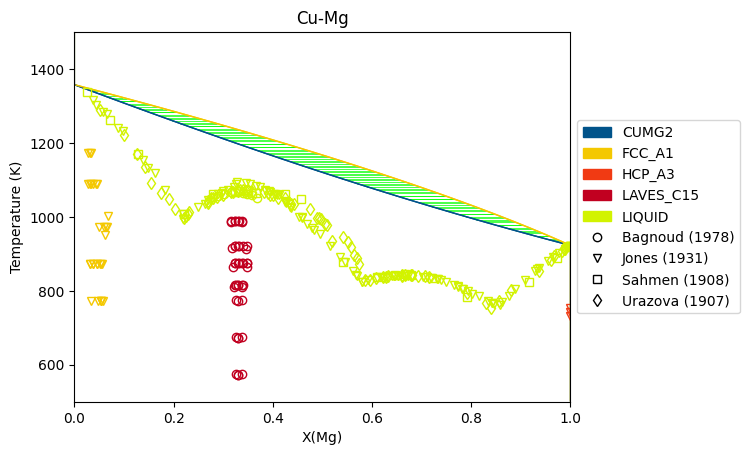

In [8]:
# load the database from after the MCMC run
dbf = Database(local_target_dir + os.sep + "Cu-Mg-mcmc.tdb")
comps = ["CU", "MG", "VA"]
phases = list(dbf.phases.keys())
conds = {v.P: 101325, v.T: (500, 1500, 10), v.X("MG"): (0, 1, 0.02)}

# plot the phase diagram and data
ax = binplot(dbf, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)
fig = ax.figure
fig.show()

## Analyzing ESPEI MCMC results

After finishing an MCMC run, you will want to analyze your results.

All of the MCMC results will be contained in two output files, which are serialized NumPy arrays. The file names are set in the `run_mcmc.yaml` file. The filenames are set by `output.tracefile` and `output.probfile` and the defaults are `trace.npy` and `lnprob.npy`, respectively.

The `tracefile` contains all of the parameters that were proposed over all chains and iterations (the trace). The `probfile` contains all of calculated log probabilities for all chains and iterations (as negative
numbers, by convention).

Running the following cell will load this data.






In [9]:
from espei.analysis import truncate_arrays, database_symbols_to_fit, optimal_parameters

# load our trace and lnprob files to use in later analysis steps
trace = np.load("trace.npy")
lnprob = np.load("lnprob.npy")
trace, lnprob = truncate_arrays(trace, lnprob)
dbf = Database("Cu-Mg-generated.tdb")
opt_params = dict(zip(database_symbols_to_fit(dbf), optimal_parameters(trace, lnprob)))

# Update the symbols in the database, this database can now be used in PyCalphad calculations
dbf.symbols.update(opt_params)
# dbf.to_file("Cu-Mg-mcmc-2.tdb")  # if desired, write out the database

ImportError: cannot import name 'database_symbols_to_fit' from 'espei.analysis' (/usr/local/lib/python3.12/dist-packages/espei/analysis.py)

*There are several aspects of your data that you may wish to analyze. The next sections will explore some of the options.*

### Probability convergence

First we'll plot how the probability changes for all of the chains as a function of iterations. This gives a qualitative view of convergence.

There are several quantitative metrics that we won't explore here, such as autocorrelation. Qualitatively, this run does not appear converged after 115 iterations.


In [ ]:
iterations = np.arange(1, trace.shape[1]+1)
fig, ax = plt.subplots()
ax.plot(iterations, lnprob.T)
ax.set_title("log-probability convergence")
ax.set_xlabel("iterations")
ax.set_ylabel("lnprob")
ax.set_yscale("symlog")  # log-probabilties are often negative, symlog gives log scale for negative numbers
fig.show()


Next we'll discard a number of iterations to account for the MCMC optimizer reaching the typical set.

After discarding the first 1000 iterations as "burn-in", we can see the chains are mixing well and exploring near the mode of the distribution.

In [ ]:
burn_in_iterations = 1000
fig, ax = plt.subplots()
ax.plot(iterations[burn_in_iterations:], lnprob[:,burn_in_iterations:].T)
ax.set_title("log-probability convergence")
ax.set_xlabel("iterations")
ax.set_ylabel("lnprob")
fig.show()

### Visualizing the trace of each parameter

We would like to see how each parameter changed during the iterations. For brevity in the number of plots we'll plot all the chains for each parameter on the same plot. Here we are looking to see how the parameters explore the space and converge to a solution.


In [ ]:
num_chains = trace.shape[0]
num_parameters = 3 # only plot the first three parameters, for all of them use `trace.shape[2]`
for parameter in range(num_parameters):
    fig, ax = plt.subplots()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Parameter value')
    for chain in range(num_chains):
        ax.plot(trace[chain, :, parameter])
plt.show()

### Corner plots

In a corner plot, the distributions for each parameter are plotted along the diagonal and covariances between them under the diagonal. A more circular covariance means that parameters are not correlated to each
other, while elongated shapes indicate that the two parameters are correlated. Strongly correlated parameters are expected for some parameters in Calphad models within phases or for phases in equilibrium,
because increasing one parameter while decreasing another would give a similar error.

In [ ]:
import corner

fig = plt.figure(figsize=(16,16)) # this is a little condensed for the web view

# flatten the along the first dimension containing all the chains in parallel
corner.corner(trace[:, burn_in_iterations:, :].reshape(-1, trace.shape[-1]), fig=fig)
fig.show()

Ultimately, there are many features available in ESPEI and pycalphad, and this example only demonstrates a few basics. Since all of the results are stored as arrays, you are free to analyze using whatever methods are relevant for your situation.

## Summary

ESPEI allows thermodynamic databases to be easily reoptimized with little user interaction, so more data can be added later and the database reoptimized at the cost of only computer time. In fact, the existing database from estimates can be used as a starting point, rather than one directly from first-principles, and the database can simply be modified to match any new data.

## Acknowledgements

This Google Colab notebook has been adapted from the documentation on the ESPEI website, and contains content and descriptions lightly edited from the original authors. Credit for initially preparing the datasets goes to Aleksei Egorov. ESPEI uses the MIT license. No license is listed for the espei.org website at the time of writing.

*PS: EJP wishes to thank the developers of pycalphad and ESPEI for their great work.*